Logistics in supply chain plays a crucial role in the inventory management of the raw materials required for the operations, The firm will like to make use of data driven approach 
using ML models so that they can predict which order can get delayed in the future and hence take preventive measures.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
# display all columns of the dataframe
pd.options.display.max_columns = 28

# import various functions from statsmodels
import statsmodels
import statsmodels.api as sm

# import various functions from sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# import various functions from sklearn 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# import function to perform feature selection
from sklearn.feature_selection import RFE

In [2]:
df=pd.read_csv(r'C:\Users\Windows 10\Downloads\Train_Set.csv')

In [3]:
df.head()

,OrderId,Customer_Id,Customer_Category,Cust_State,Zipcode,Sales,Order_zone,Price,CategoryName,Transcation,Dept_Id,Dept_Name,Profit_Ratio,Discount,Quantity,Order_Profit,Product_type,Prod_Category_Id,ProductLength,ProductWeight,Dispatched,Shipping_Class,Scheduled_Shipping,Warehouse_Region,Delivery_Review,Session_Ordered,WeekdayOrder,Delivery_Status
0,2477882,12386,Consumer,AR,19120,150.0,Central,4383.39,Cat-2,UPI,4,Apparel,0.08,0.10,3,352.78,Fragile,17,191.0,1592.0,0,Standard,4,NORTH,5.0,2.0,0,0
1,2477895,2630,Consumer,BR,2907,165.0,East,4295.72,Cat-2,UPI,4,Apparel,0.47,0.16,3,2018.10,Fragile,17,79.0,1420.0,0,Standard,6,NORTH,2.0,2.0,1,0
2,2473260,1752,Corporate,RJ,90214,171.0,South,3616.65,Cat-50,Cash,7,Fan Shop,0.26,0.07,4,939.63,Not Fragile,46,67.0,1231.0,0,Standard,6,SOUTH,4.0,2.0,0,1
3,2466916,9268,Consumer,UP,745,132.0,East,9175.86,Cat-12,Credit,4,Apparel,0.48,0.18,1,4401.74,Not Fragile,18,45.0,NaN,1,2A,4,NORTH,4.0,3.0,1,1
4,2351480,2888,Corporate,UP,92427,NaN,North,2779.29,Cat-3,UPI,5,Golf,0.13,0.16,4,361.70,Not Fragile,29,43.0,1018.0,1,Standard,5,CENTRAL,2.0,1.0,0,1


In [4]:
df.shape

(126363, 28)

In [5]:
df.isnull().sum()

OrderId                  0
Customer_Id              0
Customer_Category        0
Cust_State               0
Zipcode                  0
Sales                 3614
Order_zone               0
Price                    0
CategoryName             0
Transcation              0
Dept_Id                  0
Dept_Name                0
Profit_Ratio             0
Discount              5050
Quantity                 0
Order_Profit             0
Product_type             0
Prod_Category_Id         0
ProductLength         2946
ProductWeight          695
Dispatched               0
Shipping_Class           0
Scheduled_Shipping       0
Warehouse_Region         0
Delivery_Review       9065
Session_Ordered       4792
WeekdayOrder             0
Delivery_Status          0
dtype: int64

In [6]:
df.dtypes

OrderId                 int64
Customer_Id             int64
Customer_Category      object
Cust_State             object
Zipcode                 int64
Sales                 float64
Order_zone             object
Price                 float64
CategoryName           object
Transcation            object
Dept_Id                 int64
Dept_Name              object
Profit_Ratio          float64
Discount              float64
Quantity                int64
Order_Profit          float64
Product_type           object
Prod_Category_Id        int64
ProductLength         float64
ProductWeight         float64
Dispatched              int64
Shipping_Class         object
Scheduled_Shipping      int64
Warehouse_Region       object
Delivery_Review       float64
Session_Ordered       float64
WeekdayOrder            int64
Delivery_Status         int64
dtype: object

In [7]:
df['Sales']=df['Sales'].fillna(df['Sales'].median())
df['Discount']=df['Discount'].fillna(df['Discount'].median())
df['ProductLength']=df['ProductLength'].fillna(df['ProductLength'].median())
df['ProductWeight']=df['ProductWeight'].fillna(df['ProductWeight'].median())
df['Delivery_Review']=df['Delivery_Review'].fillna(df['Delivery_Review'].median())
df['Session_Ordered']=df['Session_Ordered'].fillna(df['Session_Ordered'].median())

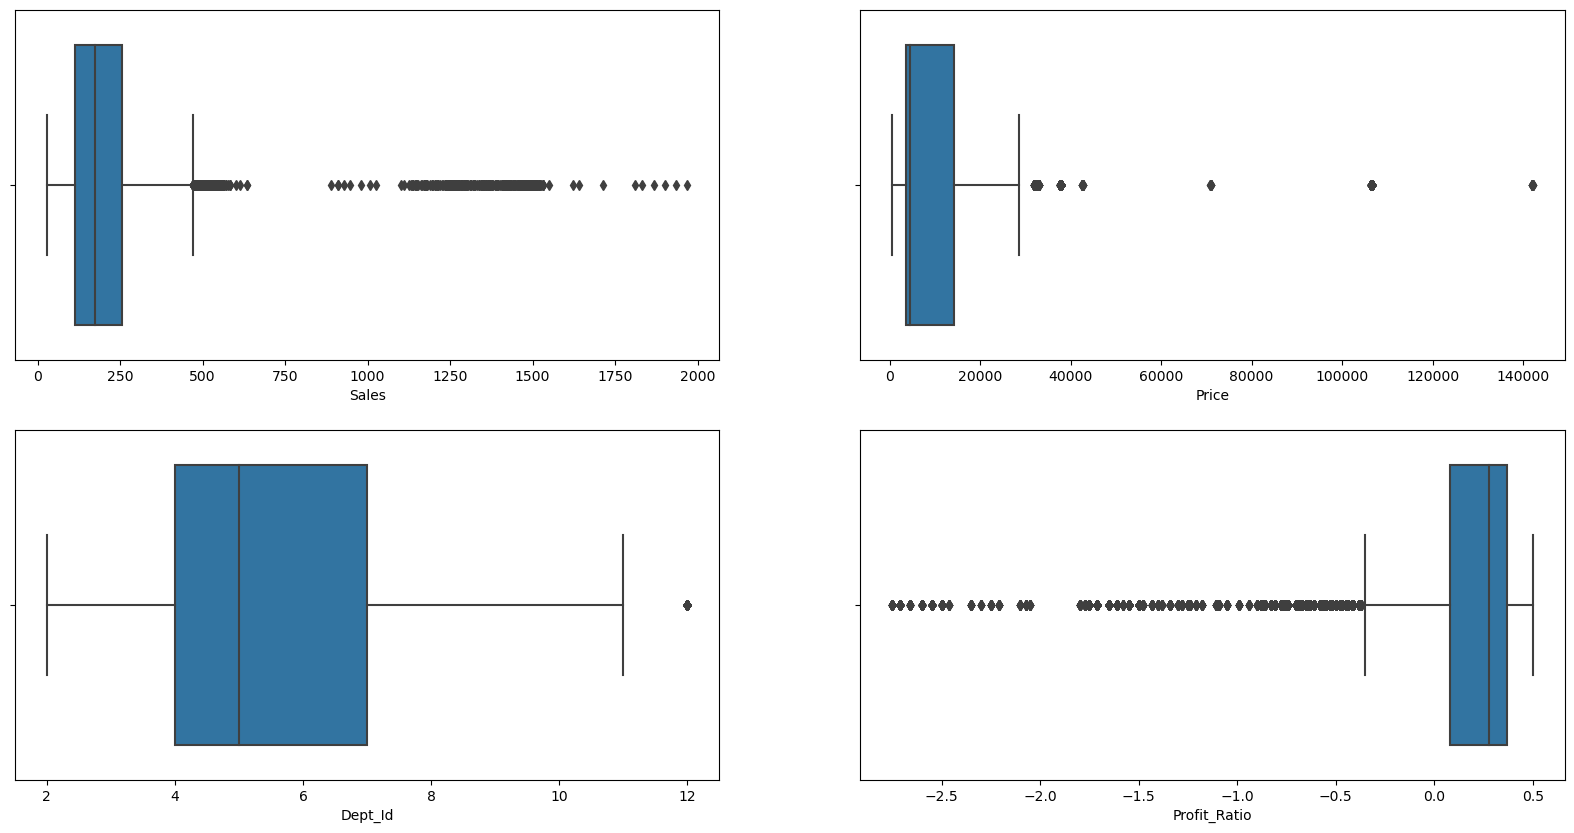

In [8]:
num=df.select_dtypes(np.number)

fig,ax=plt.subplots(nrows=2,ncols=2,figsize=[20,10])

for variable,subplot in zip(num.iloc[:,[3,4,5,6]].columns,ax.flatten()):
    sns.boxplot(num[variable],ax=subplot)
    
plt.show()


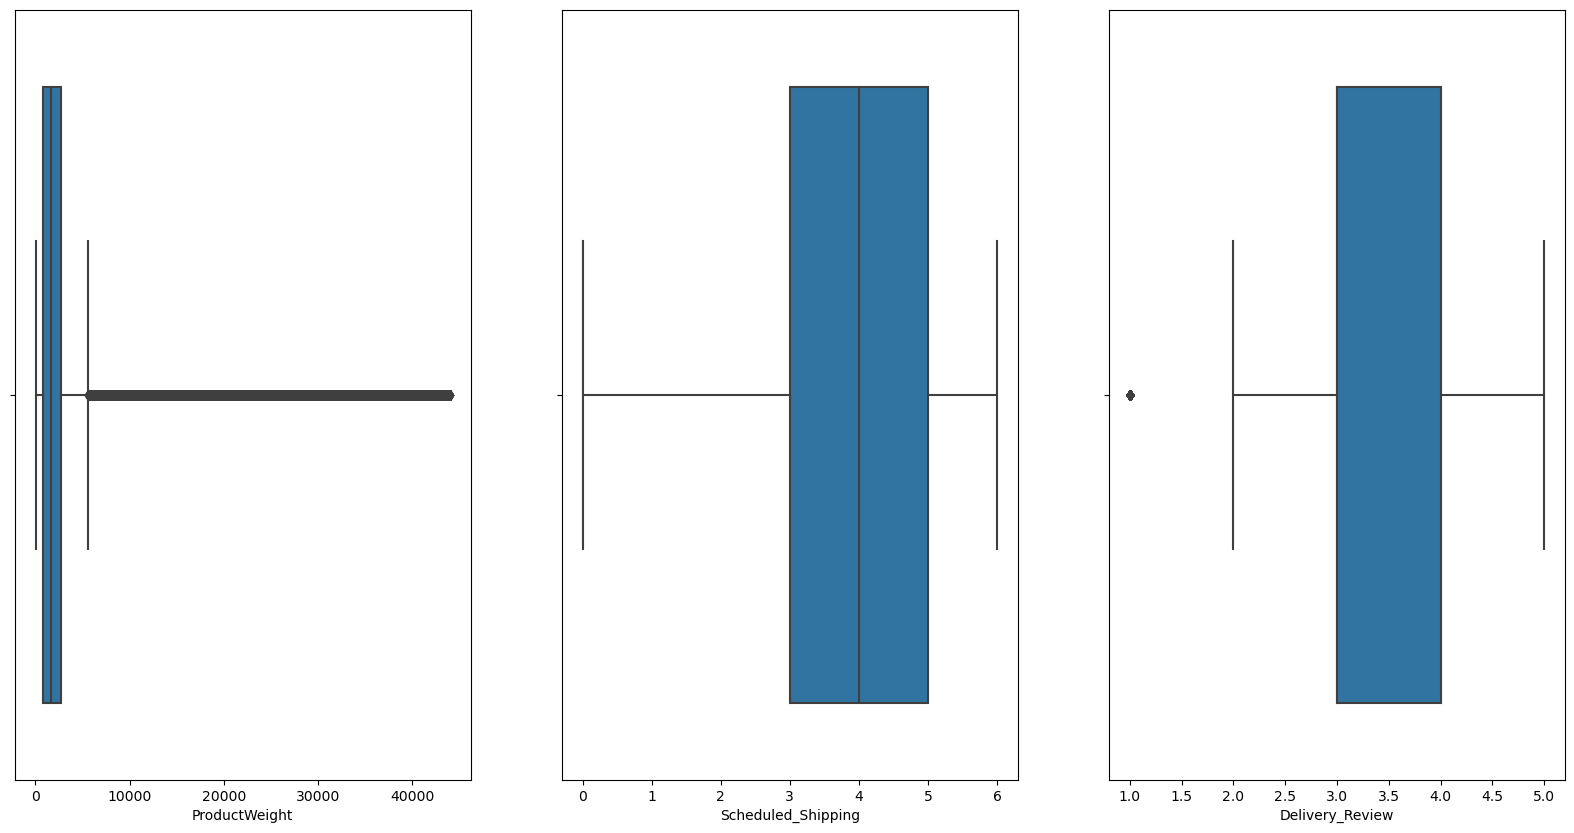

In [9]:
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=[20,10])

for variable,subplot in zip(num.iloc[:,[12,14,15]].columns,ax.flatten()):
    sns.boxplot(num[variable],ax=subplot)
    
plt.show()

In [10]:
# calculate the first quartile
Q1 = df.quantile(0.25)

# calculate the third quartile
Q3 = df.quantile(0.75)

# The Interquartile Range (IQR) is defined as the difference between the third and first quartile
# calculate IQR for each numeric variable
IQR = Q3 - Q1

# retrieve the dataframe without the outliers
# '~' returns the values that do not satisfy the given conditions 
# i.e. it returns values between the range [Q1-1.5*IQR, Q3+1.5*IQR]
# '|' is used as 'OR' operator on multiple conditions   
# 'any(axis=1)' checks the entire row for atleast one 'True' entry (the rows represent outliers in the data)
df_iqr = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# check the shape of the data
df_iqr.shape

(88778, 28)

In [11]:
df_iqr['Dispatched']=df_iqr['Dispatched'].astype('O')
df_iqr['WeekdayOrder']=df_iqr['WeekdayOrder'].astype('O')

In [12]:
df_target=df_iqr['Delivery_Status'].copy()

x=df_iqr.drop(columns=['Delivery_Status'],axis=1)

x_num=x.select_dtypes(np.number)
x_cat=x.select_dtypes('O')

In [13]:
x_num=x_num.drop(columns=['OrderId','Customer_Id','Zipcode','Dept_Id'])
x_num.head()

,Sales,Price,Profit_Ratio,Discount,Quantity,Order_Profit,Prod_Category_Id,ProductLength,ProductWeight,Scheduled_Shipping,Delivery_Review,Session_Ordered
0,150.0,4383.39,0.08,0.10,3,352.78,17,191.0,1592.0,4,5.0,2.0
1,165.0,4295.72,0.47,0.16,3,2018.10,17,79.0,1420.0,6,2.0,2.0
2,171.0,3616.65,0.26,0.07,4,939.63,46,67.0,1231.0,6,4.0,2.0
3,132.0,9175.86,0.48,0.18,1,4401.74,18,45.0,1640.0,4,4.0,3.0
4,173.0,2779.29,0.13,0.16,4,361.70,29,43.0,1018.0,5,2.0,1.0


In [14]:
from sklearn.preprocessing import StandardScaler

scale=StandardScaler()

x_num_scale=pd.DataFrame(scale.fit_transform(x_num),columns=x_num.columns)

x_num_scale.head()

,Sales,Price,Profit_Ratio,Discount,Quantity,Order_Profit,Prod_Category_Id,ProductLength,ProductWeight,Scheduled_Shipping,Delivery_Review,Session_Ordered
0,-0.244791,-0.508805,-0.843862,-0.076716,0.493822,-0.713584,-0.855731,2.043590,-0.009102,0.177914,1.893526,-0.001437
1,-0.075472,-0.522323,1.200825,0.770368,0.493822,0.183421,-0.855731,-0.186692,-0.173822,1.516062,-1.595304,-0.001437
2,-0.007744,-0.627030,0.099840,-0.500258,1.171713,-0.397484,1.115905,-0.425651,-0.354822,1.516062,0.730583,-0.001437
3,-0.447975,0.230153,1.253253,1.052729,-0.861960,1.467341,-0.787743,-0.863742,0.036866,0.177914,0.730583,1.249356
4,0.014831,-0.756144,-0.581723,0.770368,1.171713,-0.708779,-0.039881,-0.903569,-0.558807,0.846988,-1.595304,-1.252230


In [15]:
from sklearn.preprocessing import LabelEncoder

labelencoder=LabelEncoder()

x_cat_label=pd.DataFrame()

for variable in x_cat.columns:
    x_cat_label[variable]=labelencoder.fit_transform(x_cat[variable])
    
x_cat_label.head()

,Customer_Category,Cust_State,Order_zone,CategoryName,Transcation,Dept_Name,Product_type,Dispatched,Shipping_Class,Warehouse_Region,WeekdayOrder
0,0,1,0,9,3,0,0,0,3,2,0
1,0,2,1,9,3,0,0,0,3,2,1
2,1,13,3,40,0,3,1,0,3,3,0
3,0,16,1,3,1,0,1,1,1,2,1
4,1,16,2,19,3,6,1,1,3,0,0


In [16]:
x_fin=pd.concat([x_num_scale,x_cat_label],axis=1)

#x_fin.drop(columns=['index'],axis=1,inplace=True)

df_target.drop(columns=['index'],axis=1,inplace=True)

x_fin.head()

,Sales,Price,Profit_Ratio,Discount,Quantity,Order_Profit,Prod_Category_Id,ProductLength,ProductWeight,Scheduled_Shipping,Delivery_Review,Session_Ordered,Customer_Category,Cust_State,Order_zone,CategoryName,Transcation,Dept_Name,Product_type,Dispatched,Shipping_Class,Warehouse_Region,WeekdayOrder
0,-0.244791,-0.508805,-0.843862,-0.076716,0.493822,-0.713584,-0.855731,2.043590,-0.009102,0.177914,1.893526,-0.001437,0,1,0,9,3,0,0,0,3,2,0
1,-0.075472,-0.522323,1.200825,0.770368,0.493822,0.183421,-0.855731,-0.186692,-0.173822,1.516062,-1.595304,-0.001437,0,2,1,9,3,0,0,0,3,2,1
2,-0.007744,-0.627030,0.099840,-0.500258,1.171713,-0.397484,1.115905,-0.425651,-0.354822,1.516062,0.730583,-0.001437,1,13,3,40,0,3,1,0,3,3,0
3,-0.447975,0.230153,1.253253,1.052729,-0.861960,1.467341,-0.787743,-0.863742,0.036866,0.177914,0.730583,1.249356,0,16,1,3,1,0,1,1,1,2,1
4,0.014831,-0.756144,-0.581723,0.770368,1.171713,-0.708779,-0.039881,-0.903569,-0.558807,0.846988,-1.595304,-1.252230,1,16,2,19,3,6,1,1,3,0,0


In [17]:
import statsmodels
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [18]:
#X=sm.add_constant(x_fin)

df_target=df_iqr['Delivery_Status'].copy()

X_train, X_test, y_train, y_test = train_test_split(x_fin,df_target ,test_size=0.3,)

print(X_train.shape)

print(X_test.shape)

print(y_train.shape)

print(y_test.shape)

(62144, 23)
(26634, 23)
(62144,)
(26634,)


#### Create a generalized function to calculate the metrics for the test set.

In [19]:
# create a generalized function to calculate the metrics values for test set
def get_test_report(model):
    
    # for test set:
    # test_pred: prediction made by the model on the test dataset 'X_test'
    # y_test: actual values of the target variable for the test dataset

    # predict the output of the target variable from the test data 
    test_pred = model.predict(X_test)

    # return the classification report for test data
    return(classification_report(y_test, test_pred))

In [20]:
# create a generalized function to calculate the metrics values for test set
def get_train_report(model):
    
    # for test set:
    # test_pred: prediction made by the model on the test dataset 'X_test'
    # y_test: actual values of the target variable for the test dataset

    # predict the output of the target variable from the test data 
    train_pred = model.predict(X_train)

    # return the classification report for test data
    return(classification_report(y_train, train_pred))

#### Plot the confusion matrix.

In [21]:
def plot_confusion_matrix(model):
    y_pred = model.predict(X_test)
    
    # create a confusion matrix
    # pass the actual and predicted target values to the confusion_matrix()
    cm = confusion_matrix(y_test, y_pred)

    # label the confusion matrix  
    # pass the matrix as 'data'
    # pass the required column names to the parameter, 'columns'
    # pass the required row names to the parameter, 'index'
    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

    # plot a heatmap to visualize the confusion matrix
    # 'annot' prints the value of each grid 
    # 'fmt = d' returns the integer value in each grid
    # 'cmap' assigns color to each grid
    # as we do not require different colors for each grid in the heatmap,
    # use 'ListedColormap' to assign the specified color to the grid
    # 'cbar = False' will not return the color bar to the right side of the heatmap
    # 'linewidths' assigns the width to the line that divides each grid
    # 'annot_kws = {'size':25})' assigns the font size of the annotated text 
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
                linewidths = 0.1, annot_kws = {'size':25})

    # set the font size of x-axis ticks using 'fontsize'
    plt.xticks(fontsize = 20)

    # set the font size of y-axis ticks using 'fontsize'
    plt.yticks(fontsize = 20)

    # display the plot
    plt.show()

#### Plot the ROC curve.

In [22]:
def plot_roc(model):
    y_pred_prob = model.predict_proba(X_test)[:,1]
    
    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    # pass the actual target values and predicted probabilities to the function
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve for Admission Prediction Classifier', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.0, y = 0.9, s = ('AUC Score:',round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)
    
    plt.show()

### Base Model:

In [23]:
model=LogisticRegression()

base_model=model.fit(X_train,y_train)

In [36]:
base_pred=base_model.predict_proba(X_test)[:,1]

base_pred_train=base_model.predict_proba(X_train)[:,1]

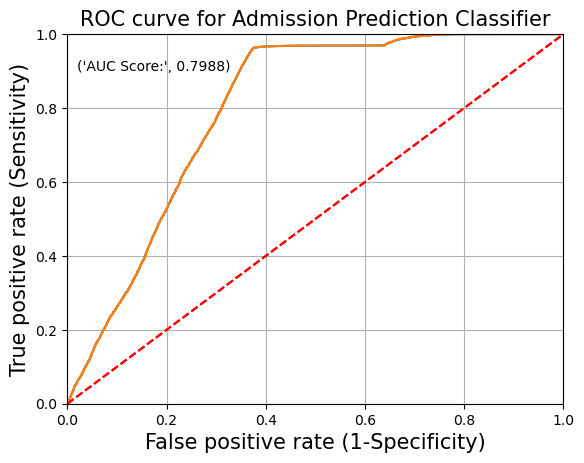

In [29]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
fpr, tpr, thresholds = roc_curve(y_test, base_pred)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Admission Prediction Classifier', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, base_pred),4)))
                               
# plot the grid
plt.grid(True)

plt.show()

In [30]:
# create a dataframe to store the values for false positive rate, true positive rate and threshold
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': thresholds})

# calculate the difference between TPR and FPR for each threshold and store the values in a new column 'Difference'
youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR

# sort the dataframe based on the values of difference 
# 'ascending = False' sorts the data in descending order
# 'reset_index' resets the index of the dataframe
# 'drop = True' drops the previous index
youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)

# print the first five observations
youdens_table.head()


,TPR,FPR,Threshold,Difference
0,0.963055,0.375591,0.247225,0.587463
1,0.962942,0.375535,0.248447,0.587407
2,0.962942,0.375591,0.248036,0.587351
3,0.962604,0.375310,0.252048,0.587294
4,0.961928,0.374634,0.254494,0.587294


In [42]:
# convert probabilities to 0 and 1 using 'if_else'
base_y_pred = [ 0 if x < 0.247225 else 1 for x in base_pred]

base_y_pred_train= [ 0 if x < 0.247225 else 1 for x in base_pred_train]

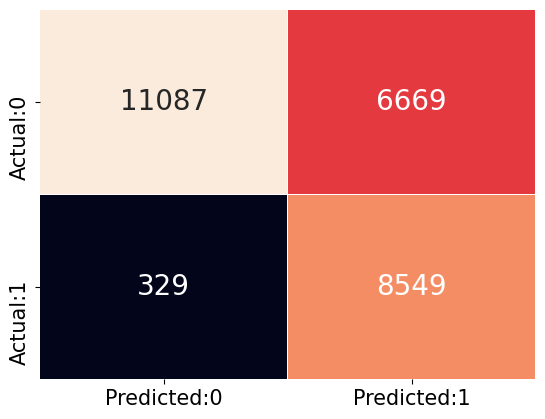

In [33]:
# create a confusion matrix
# pass the actual and predicted target values to the confusion_matrix()
cm = confusion_matrix(y_test, base_y_pred)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':20})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 15)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 15)

# display the plot
plt.show()

In [43]:
f1_score(y_test,base_y_pred)

0.709578353253652

In [44]:
f1_score(y_train,base_y_pred_train)

0.7049881749742738

In [35]:
print(classification_report(y_test,base_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76     17756
           1       0.56      0.96      0.71      8878

    accuracy                           0.74     26634
   macro avg       0.77      0.79      0.73     26634
weighted avg       0.83      0.74      0.74     26634



In [45]:
print(classification_report(y_train,base_y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.63      0.76     41920
           1       0.56      0.97      0.70     20224

    accuracy                           0.74     62144
   macro avg       0.76      0.80      0.73     62144
weighted avg       0.84      0.74      0.74     62144



### Build model using Varience inflation factor: 

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [92]:
# create an empty dataframe to store the VIF for each variable
vif = pd.DataFrame()

# calculate VIF using list comprehension 
# use for loop to access each variable 
# calculate VIF for each variable and create a column 'VIF_Factor' to store the values 
vif["VIF_Factor"] = [variance_inflation_factor(x_fin.values, i) for i in range(x_fin.shape[1])]

# create a column of variable names
vif["Features"] = x_fin.columns

# sort the dataframe based on the values of VIF_Factor in descending order
# 'ascending = False' sorts the data in descending order
# 'reset_index' resets the index of the dataframe
# 'drop = True' drops the previous index
vif.sort_values('VIF_Factor', ascending = False).reset_index(drop = True)

,VIF_Factor,Features
0,8.652013,Price
1,5.914356,CategoryName
2,5.877413,Sales
3,5.107753,Quantity
4,4.129565,Dept_Name
5,3.895674,Transcation
6,3.796325,Shipping_Class
7,3.556561,Order_Profit
8,3.256085,Cust_State
9,2.746964,Order_zone


In [94]:
# import functions to perform feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

In [95]:
# Build RF classifier to use in feature selection
log =LogisticRegression()

# Build step forward feature selection
sfs_log = sfs(log,
           k_features='best',
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs_log = sfs_log.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    8.8s finished

[2021-10-22 12:06:43] Features: 1/23 -- score: 0.695690581401621[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    8.7s finished

[2021-10-22 12:06:52] Features: 2/23 -- score: 0.695690581401621[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    9.3s finished

[2021-10-22 12:07:01] Features: 3/23 -- score: 0.695690581401621[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [98]:
log_select_feature=list(sfs_log.k_feature_names_)

In [99]:
log_X_train=X_train[log_select_feature]

log_X_test=X_test[log_select_feature]

In [106]:
model=LogisticRegression()

log_model=model.fit(log_X_train,y_train)

In [122]:
log_pred_test=log_model.predict_proba(log_X_test)[:,1]

log_pred_test

array([0.17097178, 0.08176362, 0.24545561, ..., 0.46387493, 0.183764  ,
       0.16261798])

In [123]:
log_pred_train=log_model.predict_proba(log_X_train)[:,1]

log_pred_train

array([0.47117662, 0.37123822, 0.36796871, ..., 0.73690232, 0.1457657 ,
       0.37472108])

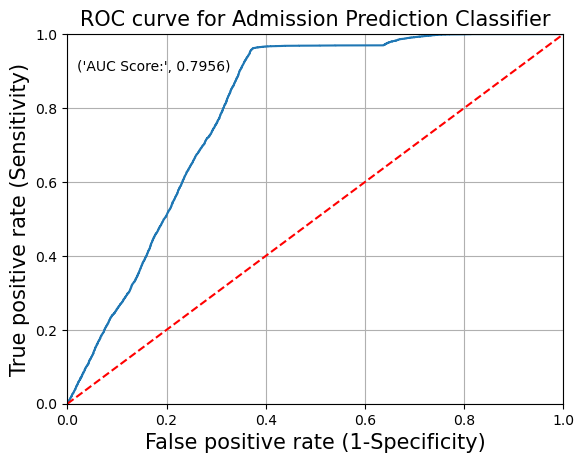

In [124]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
fpr, tpr, thresholds = roc_curve(y_test, log_pred_test)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Admission Prediction Classifier', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, log_pred),4)))
                               
# plot the grid
plt.grid(True)

plt.show()

In [110]:
# create a dataframe to store the values for false positive rate, true positive rate and threshold
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': thresholds})

# calculate the difference between TPR and FPR for each threshold and store the values in a new column 'Difference'
youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR

# sort the dataframe based on the values of difference 
# 'ascending = False' sorts the data in descending order
# 'reset_index' resets the index of the dataframe
# 'drop = True' drops the previous index
youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)

# print the first five observations
youdens_table.head()


,TPR,FPR,Threshold,Difference
0,0.961868,0.373931,0.249697,0.587937
1,0.961984,0.374098,0.248888,0.587887
2,0.961637,0.373764,0.250899,0.587872
3,0.961868,0.374098,0.249144,0.587771
4,0.961637,0.373931,0.249897,0.587706


In [127]:
# convert probabilities to 0 and 1 using 'if_else'
log_y_pred_test = [ 0 if x < 0.249697 else 1 for x in log_pred_test]
log_y_pred_train = [ 0 if x < 0.249697 else 1 for x in log_pred_train]

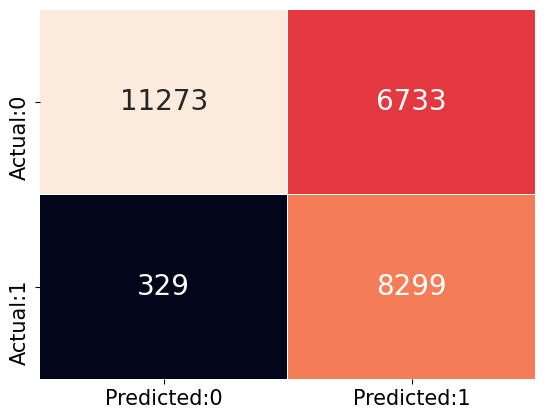

In [128]:
# create a confusion matrix
# pass the actual and predicted target values to the confusion_matrix()
cm = confusion_matrix(y_test, log_y_pred_test)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':20})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 15)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 15)

# display the plot
plt.show()

In [133]:
f1_score(y_train,log_y_pred_train)

0.7086027475775106

In [129]:
f1_score(y_test,log_y_pred_test)

0.7015215553677092

In [130]:
print(classification_report(y_test,log_y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.63      0.76     18006
           1       0.55      0.96      0.70      8628

    accuracy                           0.73     26634
   macro avg       0.76      0.79      0.73     26634
weighted avg       0.84      0.73      0.74     26634



In [131]:
print(classification_report(y_train,log_y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.63      0.76     41670
           1       0.56      0.97      0.71     20474

    accuracy                           0.74     62144
   macro avg       0.77      0.80      0.74     62144
weighted avg       0.84      0.74      0.74     62144



### XGBoost

#### Build an XGBoost model on a training dataset.

In [134]:
# import the XGBoost function for classification
from xgboost import XGBClassifier

In [138]:
# instantiate the 'XGBClassifier'
# set the maximum depth of the tree using the parameter, 'max_depth'
# pass the value of minimum loss reduction required for partition of the leaf node to the parameter, 'gamma'
xgb_model = XGBClassifier(max_depth = 10, gamma = 1)

# fit the model using fit() on train data
xgb_model.fit(log_X_train, y_train)

[12:39:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [140]:
xgb_pred_test=xgb_model.predict_proba(log_X_test)[:,1]

xgb_pred_test

array([2.6066689e-04, 3.9036563e-04, 6.3742590e-03, ..., 9.1875559e-01,
       3.0294405e-03, 6.1787019e-04], dtype=float32)

In [141]:
xgb_pred_train=log_model.predict_proba(log_X_train)[:,1]

xgb_pred_train

array([0.47117662, 0.37123822, 0.36796871, ..., 0.73690232, 0.1457657 ,
       0.37472108])

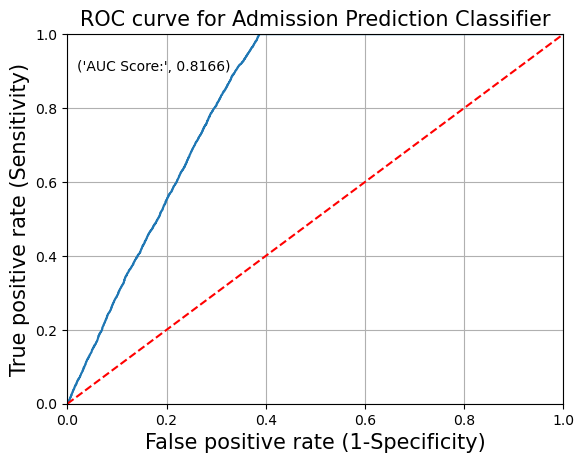

In [143]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred_test)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Admission Prediction Classifier', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, xgb_pred_test),4)))
                               
# plot the grid
plt.grid(True)

plt.show()

In [144]:
# create a dataframe to store the values for false positive rate, true positive rate and threshold
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': thresholds})

# calculate the difference between TPR and FPR for each threshold and store the values in a new column 'Difference'
youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR

# sort the dataframe based on the values of difference 
# 'ascending = False' sorts the data in descending order
# 'reset_index' resets the index of the dataframe
# 'drop = True' drops the previous index
youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)

# print the first five observations
youdens_table.head()


,TPR,FPR,Threshold,Difference
0,0.999652,0.386982,0.057923,0.612670
1,0.999536,0.386927,0.060718,0.612610
2,0.999536,0.386982,0.060647,0.612554
3,0.999768,0.387260,0.038487,0.612508
4,0.999884,0.387426,0.035102,0.612458


In [145]:
# convert probabilities to 0 and 1 using 'if_else'
xgb_y_pred_test = [ 0 if x < 0.057923 else 1 for x in xgb_pred_test]
xgb_y_pred_train = [ 0 if x < 0.057923 else 1 for x in xgb_pred_train]

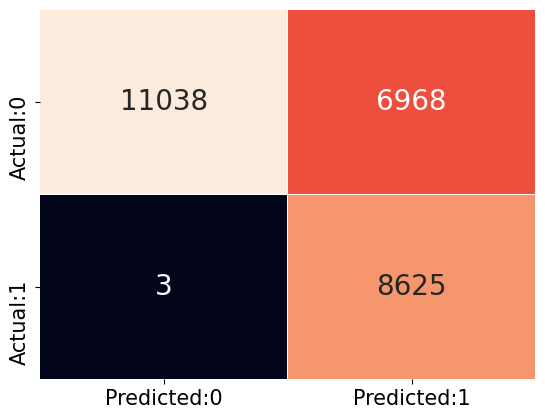

In [147]:
# create a confusion matrix
# pass the actual and predicted target values to the confusion_matrix()
cm = confusion_matrix(y_test, xgb_y_pred_test)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':20})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 15)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 15)

# display the plot
plt.show()

In [148]:
f1_score(y_test,xgb_y_pred_test)

0.7121918995912636

In [149]:
print(classification_report(y_test,xgb_y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.61      0.76     18006
           1       0.55      1.00      0.71      8628

    accuracy                           0.74     26634
   macro avg       0.78      0.81      0.74     26634
weighted avg       0.86      0.74      0.74     26634



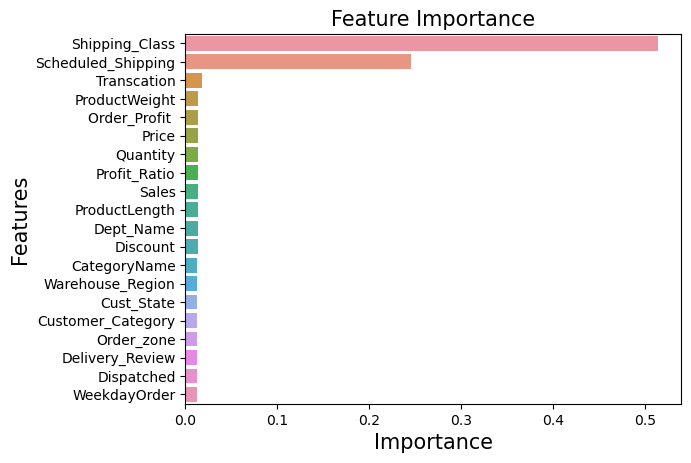

In [152]:
# create a dataframe that stores the feature names and their importance
# 'feature_importances_' returns the features based on the average gain 
important_features = pd.DataFrame({'Features': log_X_train.columns, 
                                   'Importance': xgb_model.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

### Random Forest for Classification

#### Build an RandomForestClassifier model on a training dataset.

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
# instantiate the 'RandomForestClassifier'
# pass the required number of trees in the random forest to the parameter, 'n_estimators'
# pass the 'random_state' to obtain the same samples for each time you run the code
rf_classification = RandomForestClassifier(n_estimators = 10, random_state = 10)

# use fit() to fit the model on the train set
rf_model = rf_classification.fit(X_train, y_train)

In [53]:
rfc_pred_test=rf_classification.predict_proba(X_test)[:,1]

rfc_pred_train=rf_classification.predict_proba(X_train)[:,1]

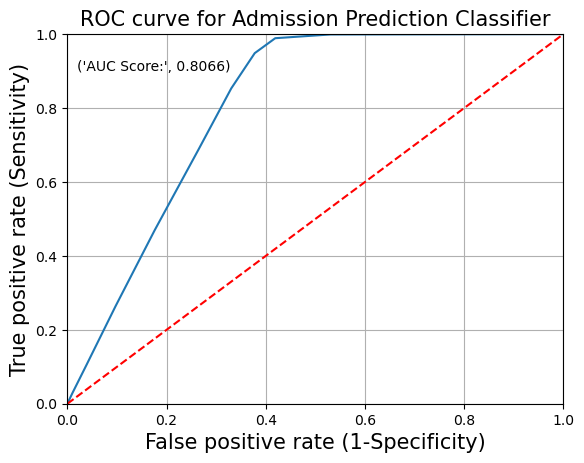

In [54]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
fpr, tpr, thresholds = roc_curve(y_test, rfc_pred_test)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve for Admission Prediction Classifier', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, rfc_pred_test),4)))
                               
# plot the grid
plt.grid(True)

plt.show()

In [55]:
# create a dataframe to store the values for false positive rate, true positive rate and threshold
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': thresholds})

# calculate the difference between TPR and FPR for each threshold and store the values in a new column 'Difference'
youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR

# sort the dataframe based on the values of difference 
# 'ascending = False' sorts the data in descending order
# 'reset_index' resets the index of the dataframe
# 'drop = True' drops the previous index
youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)

# print the first five observations
youdens_table.head()

,TPR,FPR,Threshold,Difference
0,0.948524,0.377675,0.3,0.570849
1,0.988961,0.419013,0.2,0.569948
2,0.853233,0.330367,0.4,0.522866
3,0.999099,0.530525,0.1,0.468574
4,0.687993,0.264418,0.5,0.423575


In [61]:
    # convert probabilities to 0 and 1 using 'if_else'
    rfc_y_pred_test = [ 0 if x < 0.3 else 1 for x in rfc_pred_test]
    rfc_y_pred_train = [ 0 if x < 0.3 else 1 for x in rfc_pred_train]

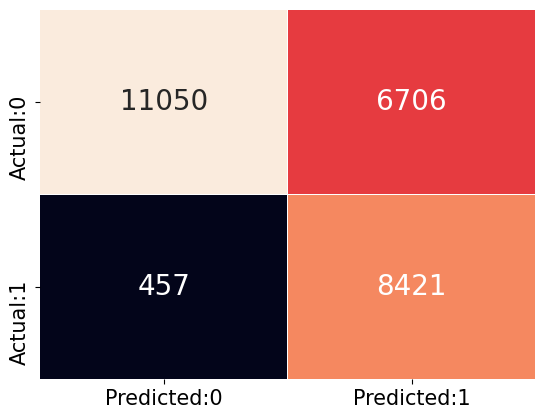

In [62]:
# create a confusion matrix
# pass the actual and predicted target values to the confusion_matrix()
cm = confusion_matrix(y_test, rfc_y_pred_test)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':20})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 15)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 15)

# display the plot
plt.show()

In [63]:
f1_score(y_test,rfc_y_pred_test)

0.7016038325348886

In [64]:
print(classification_report(y_test,rfc_y_pred_test))

              precision    recall  f1-score   support

           0       0.96      0.62      0.76     17756
           1       0.56      0.95      0.70      8878

    accuracy                           0.73     26634
   macro avg       0.76      0.79      0.73     26634
weighted avg       0.83      0.73      0.74     26634



In [65]:
    print(classification_report(y_train,rfc_y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94     41920
           1       0.80      1.00      0.89     20224

    accuracy                           0.92     62144
   macro avg       0.90      0.94      0.91     62144
weighted avg       0.94      0.92      0.92     62144



In [66]:
from sklearn.feature_selection import SelectFromModel

In [67]:
### Apply Feature Selection
# first, I specify the Lasso Regression model, and I
# select a suitable alpha (equivalent of penalty).
# The bigger the alpha the less features that will be selected.

# Then I use the selectFromModel object from sklearn, which
# will select the features which coefficients are non-zero

feature_sel_model = SelectFromModel(LogisticRegression()) # remember to set the seed, the random state in this function
feature_sel_model.fit(X_train, y_train)

SelectFromModel(estimator=LogisticRegression())

In [69]:
# let's print the number of total and selected features

# this is how we can make a list of the selected features
selected_feat = X_train.columns[(feature_sel_model.get_support())]

# let's print some stats
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(feature_sel_model.estimator_.coef_ == 0)))

total features: 23
selected features: 2
features with coefficients shrank to zero: 0


In [70]:
selected_feat

Index(['Scheduled_Shipping', 'Shipping_Class'], dtype='object')

In [71]:
new_X_train=X_train[selected_feat]

new_X_test=X_test[selected_feat]

In [74]:
new_log=LogisticRegression()

new_log=new_log.fit(new_X_train,y_train)

In [76]:
new_pred_test=new_log.predict_proba(new_X_test)[:,1]

new_pred_train=new_log.predict_proba(new_X_train)[:,1]

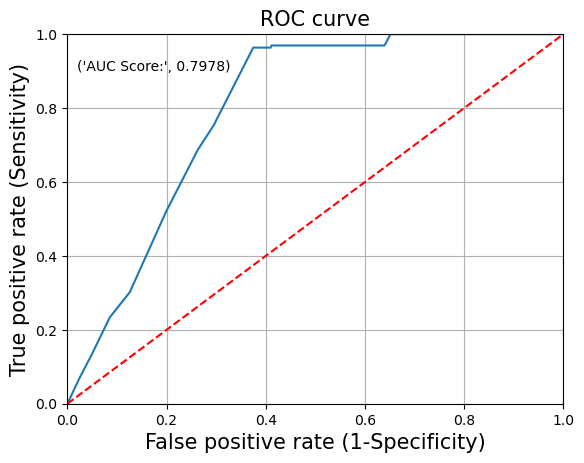

In [78]:
# the roc_curve() returns the values for false positive rate, true positive rate and threshold
# pass the actual target values and predicted probabilities to the function
fpr, tpr, thresholds = roc_curve(y_test, new_pred_test)

# plot the ROC curve
plt.plot(fpr, tpr)

# set limits for x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# plot the straight line showing worst prediction for the model
plt.plot([0, 1], [0, 1],'r--')

# add plot and axes labels
# set text size using 'fontsize'
plt.title('ROC curve', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

# add the AUC score to the plot
# 'x' and 'y' gives position of the text
# 's' is the text 
# use round() to round-off the AUC score upto 4 digits
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, new_pred_test),4)))
                               
# plot the grid
plt.grid(True)

plt.show()

In [79]:
# create a dataframe to store the values for false positive rate, true positive rate and threshold
youdens_table = pd.DataFrame({'TPR': tpr,
                             'FPR': fpr,
                             'Threshold': thresholds})

# calculate the difference between TPR and FPR for each threshold and store the values in a new column 'Difference'
youdens_table['Difference'] = youdens_table.TPR - youdens_table.FPR

# sort the dataframe based on the values of difference 
# 'ascending = False' sorts the data in descending order
# 'reset_index' resets the index of the dataframe
# 'drop = True' drops the previous index
youdens_table = youdens_table.sort_values('Difference', ascending = False).reset_index(drop = True)

# print the first five observations
youdens_table.head()

,TPR,FPR,Threshold,Difference
0,0.963505,0.374690,0.302627,0.588815
1,0.969250,0.411410,0.191997,0.557840
2,0.963505,0.409721,0.215371,0.553785
3,0.763798,0.298829,0.333903,0.464970
4,0.755238,0.295844,0.366712,0.459394


In [80]:
# convert probabilities to 0 and 1 using 'if_else'
new_y_pred_test = [ 0 if x < 0.3 else 1 for x in new_pred_test]
new_y_pred_train = [ 0 if x < 0.3 else 1 for x in new_pred_train]

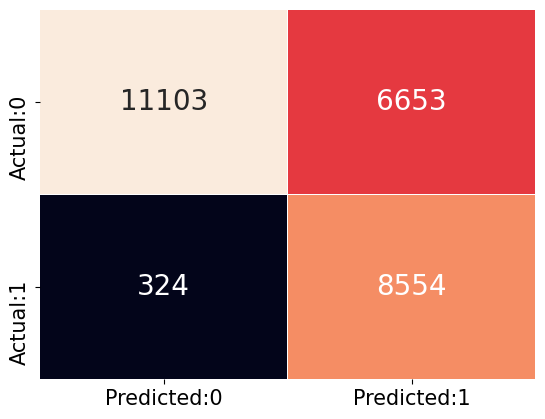

In [81]:
# create a confusion matrix
# pass the actual and predicted target values to the confusion_matrix()
cm = confusion_matrix(y_test, new_y_pred_test)

# label the confusion matrix  
# pass the matrix as 'data'
# pass the required column names to the parameter, 'columns'
# pass the required row names to the parameter, 'index'
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

# plot a heatmap to visualize the confusion matrix
# 'annot' prints the value of each grid 
# 'fmt = d' returns the integer value in each grid
# 'cmap' assigns color to each grid
# as we do not require different colors for each grid in the heatmap,
# use 'ListedColormap' to assign the specified color to the grid
# 'cbar = False' will not return the color bar to the right side of the heatmap
# 'linewidths' assigns the width to the line that divides each grid
# 'annot_kws = {'size':25})' assigns the font size of the annotated text 
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False, 
            linewidths = 0.1, annot_kws = {'size':20})

# set the font size of x-axis ticks using 'fontsize'
plt.xticks(fontsize = 15)

# set the font size of y-axis ticks using 'fontsize'
plt.yticks(fontsize = 15)

# display the plot
plt.show()

In [82]:
f1_score(y_test,new_y_pred_test)

0.7103176250778492

In [83]:
print(classification_report(y_test,new_y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.63      0.76     17756
           1       0.56      0.96      0.71      8878

    accuracy                           0.74     26634
   macro avg       0.77      0.79      0.74     26634
weighted avg       0.84      0.74      0.74     26634



In [84]:
print(classification_report(y_train,new_y_pred_train))

              precision    recall  f1-score   support

           0       0.97      0.63      0.76     41920
           1       0.56      0.97      0.71     20224

    accuracy                           0.74     62144
   macro avg       0.77      0.80      0.73     62144
weighted avg       0.84      0.74      0.75     62144

